In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feyn

# Using QLattice to understand caspase activation in antisense oligonucleotides


# Background

An antisense oligonucleotide (ASO) is a small strand of DNA, typically not longer than 20 nucleobases, which is designed to be the reverse complement of a mRNA occuring in the organism. The ASO will bind to the target mRNA by Watson-Crick base pairing and thereby modulate its function
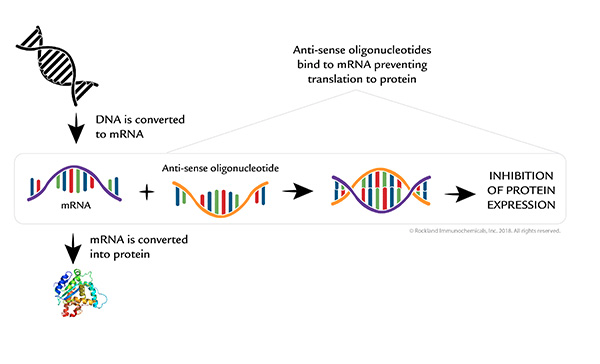

## A flexible and powerful drug
It is in principle possible to design an ASO in such a way that it will modulate *any* target mRNA. Also, ASOs of arbitrary base sequences can be manufactured accurately and efficiently. ASOs have therefore been thought of as a very promising and flexible mechanism to modulate virtually any process in the organism.

In practice a number of serious challenges have shown up that have limited their use. To date, only a handful of ASO based drugs have been approved, and an additional 25 drugs are in clinical trial stage II or III. These problems include *toxicity*, *potency*, and *delivery*.

In this notebook, we will demonstrate how to use the *QLattice* to gain understanding that can help design less toxic and more potent ASO drugs.

## Toxicity
In practice many ASOs have a significant cytotoxic potential (their presence in the cell causes the cell to die). There is much reseach but very little actual understading about why some ASOs are cytotoxic while others are not. Often even small variations in the design of an ASO can change it from non-toxic to highly toxic.

Even for ASOs that have the exact same sequence of nucleobases, the toxicity can vary with other modifications to the molecule. In practice, ASOs always have modifications to make them more stable, since unmodified DNA strings are not stable and will immediately be degraded inside the cell.

## Locked Nucleic Acid (LNA)
In order to stabilize ASOs various kinds of modifications to the nucleobases in the seqeunce can be made. One popular modification is called LNA. This method was invented in 1997 by Obika et al., and independently in 1998 by Jesper Wengel's research group in 1998.

In this notebook we will represent ASOs in writing as strings of nucleobases with the convention that bases that modified to be LNA will be written in uppercase, while unmodified DNA will be written with the base letter in lowercase, like this:

<big>```TGGCaagcatccTGTA```</big>
n
This seqeuence starts with four LNA bases (`TGGC`), then continues with eight DNA bases (`aagcatcc`) and ends with another four LNA bases (`TGTA`).

## Gapmers
The term gapmers refers to ASOs with designs such as this. The LNA sequences in the beginning and the end of the ASO are called the *flanks*, while the unmodified DNA sequence in the middle is called the *gap*.
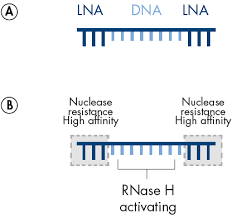


## Generalisation
Many studies have applied traditional machine learning methods such as random forest and gradient boosting to predict ASO toxicity. A problem with this type of *black box* predictions is that often do not generalise to new experiments.

A machine learning model may perform well on train/test splits of the original experimental data, but the model has little or no predictive power on a new data set from a new experiment, where the ASOs are designed with different design criteria in mind. This is the *curse of curve-fitting*. One cannot expect a fitted curve to generalise beyond the data it was fitted on.

The solution to this is real scientific understanding. 

> Kepler's law of planetary motion will tell you the location of Mars at any point in time from the deep past to the distant future. A machine learning model fitted on observations of the Mars orbit will not work very far into the past or future.

The QLattice is a machine learning method designed to give results that are more like Kepler's laws and less like a fitted curve. It does so by finding the simplest mathematical relationship that will explain observations.

# Data set
The data set used in this notebook comes from a [2019 research paper by Natalia Papargyri et al](https://doi.org/10.1016/j.omtn.2019.12.011) from Roche Pharma Research. The data set contains the design of 768 different gapmers. The gapmers target one of two regions on the mRNA. 386 of them a region we will call **region A**, and 386 of them target a region we will call **region B**. (Four of the ASOs target neither of the regions and were included in the original study as inactive controls. We will not use those four ASOs in this notebook).

> For the curious: Both region A and B are located on the hypoxia-inducible factor 1-alpha (HIF1A) mRNA. The HIF1A protein regulates cellular responses to hypoxia, and elevated expression of HIF1A has been associated with poor prognosis for many types of cancer.


In [ ]:
df=pd.read_csv("gapmer_data_clean.csv")
df

## Description of the fields:

- **target**: A or B, indicates which region in HIF1A is targeted.
- **sequence**: The sequence of the ASO. lowercase means DNA, uppercase means LNA
- **design**: The gapmer design. Each char is either L or D for LNA or DNA.
- **cas_avg**: The average caspase activation across several measurements. Low caspase means that the ASO is safe, high caspase means that the ASO is toxic
- **kd_avg**: Average knockdown. How potent the ASO is in reducing the targeted mRNA. It is expressed as a percentage of the mRNA remaining, so a low value means a potent drug, while a value close to 100 means the mRNA wasn't knocked down by the ASO. 

In this notebook we will build models to understand and predict caspase. We have used exactly the same dataset to understand and predict knockdown with equally good results, but we will leave doing so as a challenge for the reader.

# Method

In this notebook we will use the QLattice to fit a mathematical model to predict caspase activation on the gapmers targeting **region A**. In the work, we will completely disregard the ASOs targeting **region B**.

The ASOs targeting region A all consist of exactly the same sequence of nucleobases, since they all target the same region of the mRNA. This sequence is:

```tggcaagcatcctgta```

They differ from each other in two ways: they are either 13 or 16 bases long, and the location of the LNA modifications. It is important to note that there can actually be DNA in the flanks. What we call the *gap* is the consecutive region on DNA of at least six bases in the middle of the desing.
> The reason we don't think of DNA bases embedded in the flanks as additional gaps, is that the DNA sequence needs to be at least six bases long to recruit RNase H1 to cleave the mRNA. 

### A sample of the ASOs targeting region A:

In [ ]:
df[df["target"]=='A']["sequence"].sample(10)

## 5' and 3' flanks
The backbone of a DNA string is made in a way that allows us to define which end is which in a DNA molecule. In other words: A DNA molecule has direction. For chemical reasons, one end of a molecule is called the 5' end and the other is called the 3' end. 

Conventionally a DNA string is written with the 5' end to the left and the 3' end to the right. This means that we can define a 5' flank and a 3' flank.

Since we know that the ASOs differ from each other only in the configuration of LNAs, we will be generating a model that explains caspase activation from the LNA/DNA configuration only.

> We have worked a lot with ASOs and know that attributes of the actual sequence have a significant impact on the toxicity of ASOs, and so does the attributes of the target mRNA besides its sequence. But since *this* data set has no variation in the sequence, only in the design, we will only look at design in this notebook. 
> This also means that we know from the start that our model will never explain the full picture of caspase activation, and in other words that the predictive power will be less than perfect.

## Engineer features capturing the design
We will engineer four features based on the design that capture some of its attributes.

- **lna_5p**: The number of LNA nucleobases in the *left* flank. Embedded DNA bases are not counted
- **lna_3p**: The number of LNA nucleobases in the *right* flank. Embedded DNA bases are not counted
- **lna_count**: The number of LNA nucleobases across the ASO
- **dna_count**: The number of DNA nucleobases across the ASO

Note that there is some redundancy here: $ lna\_count = lna\_5p + lna\_3p $. We include it nonetheless to allow the QLattice to choose whether to distinguish between the 5' and the 3' end or not.

In [ ]:
df["lna_5p"] = df["design"].str[:5].str.count("L")
df["lna_3p"] = df["design"].str[-5:].str.count("L")
df["lna_count"] = df["design"].str.count("L")
df["dna_count"] = df["design"].str.count("D")
df["aso_len"] = df["design"].str.len()



# Toxicity predictor

The scatterplots below show the measured caspase activation on the y axis and the measured knockdown on the x axis for each of the two target regions.

It is clear that the ASOs targeting region A are more toxic than the ASOs targeting region B. We can assume that this has to do with the sequence or the target, rather than the design.

Since there is this difference, it's difficult - although not impossible - to fit a regression model on A and test whether it generalizes to B. For simplicity we will instead fit a classifier to determine whether an ASO is too toxic or not.

Previous work has shown that reasonable threshold for caspase activation is 300%. [(Deickmann, 2018)](https://doi.org/10.1016/j.omtn.2017.11.004). We will use this as the cutoff value for training the QLattice classifier model

In [ ]:
# Define toxicity threshold
df["too_toxic"] = df["cas_avg"]>300

# Split the dataset in region A and B
dfA = df[df["target"]=="A"]
dfB = df[df["target"]=="B"]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

ax1.scatter(x=dfA["kd_avg"], y=dfA["cas_avg"])
ax1.set_title("region A")
ax1.set_xlabel("knockdown")
ax1.set_ylabel("caspase activation (% )")

ax2.scatter(x=dfB["kd_avg"], y=dfB["cas_avg"], c="#aaaaba")
ax2.set_title("region B")
ax2.set_xlabel("knockdown")
ax2.set_ylabel("caspase activation %");


## The final dataset

The final dataset looks like this.

In [ ]:
dfA

We will use the design specific features *lna_5p*, *lna_3p*, *dna_count*, *lna_count* and *aso_len* to fit the toxicity classifier.

In [ ]:
features = ["lna_5p","lna_3p", "dna_count", "lna_count", "aso_len"]

# The QLattice

The QLattice is the core of Abzu's technology. It lives on a computing cluster operated by Abzu, and serves as the **source of models** linking concepts together. 

> In order to connect to and use a QLattice you need get one from Abzu. QLattices are a limited resource, but we do offer them for free for scientific purposes. 
> To access it from your computer, you need to install a software development kit (SDK).

The following lines of code connects to the QLattice, resets it to a blank state which erases any preivous learning, and reguests a classifier QGraph that will compute the `too_toxic` property from the input features.

In [ ]:
ql = feyn.QLattice()
ql.reset(1)
qg = ql.get_classifier(features, "too_toxic", max_depth=2)

## Sorting the infinite list


In [ ]:
for _ in range(30):
    qgn.fit(dfA, threads=7, criterion="aic")
    ql.update(qgn.best())

In [ ]:
qgn[0].plot_partial2d(dfB)

In [ ]:
qgn[0].plot_roc_curve(dfA, label="Target A (training)")
qgn[0].plot_roc_curve(dfB, label="Target B (validation)")

In [ ]:
qgn[0].plot_summary(dfB)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(dfA[features], dfA["too_toxic"])

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(dfA[features], dfA["too_toxic"])

In [ ]:
feyn.plots.plot_roc_curve(dfB["too_toxic"], rf.predict_proba(dfB[features])[:,1], label="RF")
feyn.plots.plot_roc_curve(dfB["too_toxic"], gb.predict_proba(dfB[features])[:,1], label="GB");

In [ ]:
qgn[0].sympify(1)